## Test module Conv1D

In [3]:
import sys
sys.path.insert(0, '../src')

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns
"""
Utils
"""
from termcolor import colored
from mltools import plot_data, plot_frontiere, make_grid, gen_arti
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from tqdm import tqdm
import time
import random
import pandas as pd
import csv

"""
Modules principaux
"""
from Sequentiel import Sequentiel
from Optim import SGD, Optim
from Linear import Linear
from Flatten import Flatten
from Conv1D import Conv1D
from MaxPool1D import MaxPool1D
from AvgPool1D import AvgPool1D
"""
Activation
"""
from activation.Softmax import Softmax
from activation.Sigmoide import Sigmoide
from activation.TanH import TanH
from activation.ReLU import ReLU
"""
Loss
"""
from loss.MSELoss import MSELoss
from loss.CELoss import CELoss
from loss.BCELoss import BCELoss
from loss.CELogSoftmax import CELogSoftmax as CELogSM

In [4]:
def OneHotEncoding(y):
    onehot = np.zeros((y.size,y.max()+1))
    onehot[np.arange(y.size),y]=1
    return onehot

# affichage d'une lettre
def tracerLettre(let):
    a = -let*np.pi/180 # conversion en radx
    coord = np.array([[0, 0]]) # point initial
    for i in range(len(a)):
        x = np.array([[1, 0]])
        rot = np.array([[np.cos(a[i]), -np.sin(a[i])],[ np.sin(a[i]),np.cos(a[i])]])
        xr = x.dot(rot) # application de la rotation
        coord = np.vstack((coord,xr+coord[-1,:]))
    plt.figure()
    plt.plot(coord[:,0],coord[:,1])
    plt.show()
    # plt.savefig("exlettre.png")

def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

In [12]:
def main_Conv1d():
    # Pour utiliser les données usps
    # Load Data From USPS , directement pris depuis TME4
    uspsdatatrain = "data/USPS_train.txt"
    uspsdatatest = "data/USPS_test.txt"
    alltrainx, alltrainy = load_usps(uspsdatatrain)
    alltestx, alltesty = load_usps(uspsdatatest)

    input = len(alltrainx[0])
    output = len(np.unique(alltesty))
    alltrainy_oneHot = OneHotEncoding(alltrainy)
    alltesty_oneHot = OneHotEncoding(alltesty)

    alltrainx /= 2
    alltestx /= 2

    print(alltrainx.shape)

    alltrainx = alltrainx.reshape(alltrainx.shape[0], alltrainx.shape[1], 1)
    alltestx = alltestx.reshape(alltestx.shape[0], alltestx.shape[1], 1)

    print(alltrainx.shape)

    # ----------------------- MNIST DATASET

    # nom_fichier_train =  "data/mnist_train.csv"
    # nom_fichier_test =  "data/mnist_test.csv"

    # data_train =  pd.read_csv(nom_fichier_train).to_numpy()
    # data_test =  pd.read_csv(nom_fichier_test).to_numpy()
    # alltrainx,alltrainy = data_train[:,1:].astype('float32') , data_train[:,0]
    # alltestx, alltesty = data_test[:,1:].astype('float32') , data_test[:,0]
    
    # alltrainx /= 255
    # alltestx /= 255

    # alltrainy_oneHot = OneHotEncoding(alltrainy)
    # alltesty_oneHot = OneHotEncoding(alltesty)

    # print(alltrainx.shape)

    # alltrainx = alltrainx.reshape(alltrainx.shape[0], alltrainx.shape[1], 1)
    # alltestx = alltestx.reshape(alltestx.shape[0], alltestx.shape[1], 1)
    # print(alltrainx.shape)

    iteration = 10
    gradient_step = 1e-3
    batch_size = 50

    l1 = Conv1D(3, 1, 32,biais=False)
    l2 = AvgPool1D(2, 2)
    l3 = Flatten()
    l4 = Linear(4064, 100)
    l5 = ReLU(0)
    l6 = Linear(100, alltrainy_oneHot.shape[1])
    l7 = Softmax()

    model = Sequentiel(l1, l2, l3, l4, l5, l6)
    loss = CELogSM()
    opt = SGD(model, loss, alltrainx, alltrainy_oneHot, batch_size, nbIter=iteration, eps=gradient_step)


    list_loss = opt.update()

    # Predection
    predict = model.forward(alltrainx)
    predict = np.argmax(predict, axis=1)

    predict_test = model.forward(alltestx)
    predict_test = np.argmax(predict_test, axis=1)

    print(predict.shape)
    print(alltrainy.shape)

    print("Precision sur l'ensemble d'entrainement",((np.sum(np.where(predict == alltrainy, 1, 0)) / len(predict))*100),"%")
    print("Precision sur l'ensemble de test",((np.sum(np.where(predict_test == alltesty, 1, 0)) / len(predict_test))*100),"%")

    taux_train = ((np.argmax( opt.net.forward(alltrainx),axis = 1) == alltrainy).mean()*100)
    taux_test = ((np.argmax( opt.net.forward(alltestx),axis = 1) == alltesty).mean()*100)
    print("Taux de bonne classification en train : ",taux_train,"%")
    print("Taux de bonne classification en test : ",taux_test,"%")

    """
    AFFICHAGE DE LA LOSS
    """
    plt.figure()
    plt.xlabel("nombre d'iteration")
    plt.ylabel("Erreur CE")
    plt.title("Evolution de l'erreur")
    plt.plot(list_loss,label="Erreur")
    plt.legend()
    plt.show()

    # Confusion Matrix
    plt.figure()
    confusion = confusion_matrix(predict, alltrainy)
    ax = sns.heatmap(confusion, annot=True, cmap='Blues')
    ax.set_title(f"Matrice de confusion pour données USPS Train \ acc = {taux_train}%\n\n")
    ax.set_xlabel('\nChiffre prédit')
    ax.set_ylabel('Vrai chiffre ')
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(np.arange(10))
    ax.yaxis.set_ticklabels(np.arange(10))
    ## Display the visualization of the Confusion Matrix.
    plt.show()


    # Confusion Matrix
    plt.figure()
    confusion = confusion_matrix(predict_test, alltesty)
    ax = sns.heatmap(confusion, annot=True, cmap='Blues')
    ax.set_title(f"Matrice de confusion pour données USPS Test \ acc = {taux_test}%\n\n")
    ax.set_xlabel('\nChiffre prédit')
    ax.set_ylabel('Vrai chiffre ')
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(np.arange(10))
    ax.yaxis.set_ticklabels(np.arange(10))
    ## Display the visualization of the Confusion Matrix.
    ## It still not beautiful I can't find out why
    plt.show()

(7291, 256)
(7291, 256, 1)


100%|██████████| 10/10 [01:06<00:00,  6.66s/it]


(7291,)
(7291,)
Precision sur l'ensemble d'entrainement 91.55122754080372 %
Precision sur l'ensemble de test 82.85999003487792 %
Taux de bonne classification en train :  91.55122754080372 %
Taux de bonne classification en test :  82.85999003487792 %


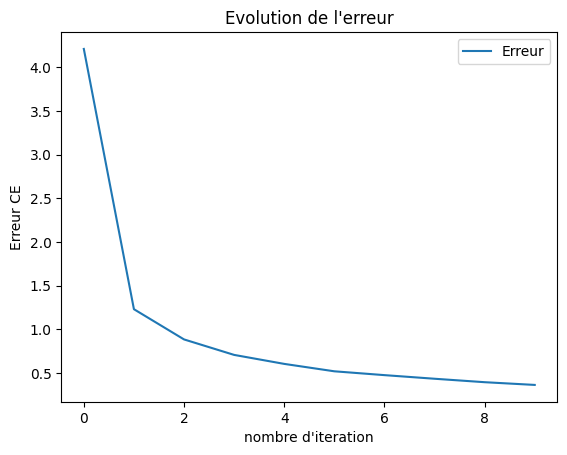

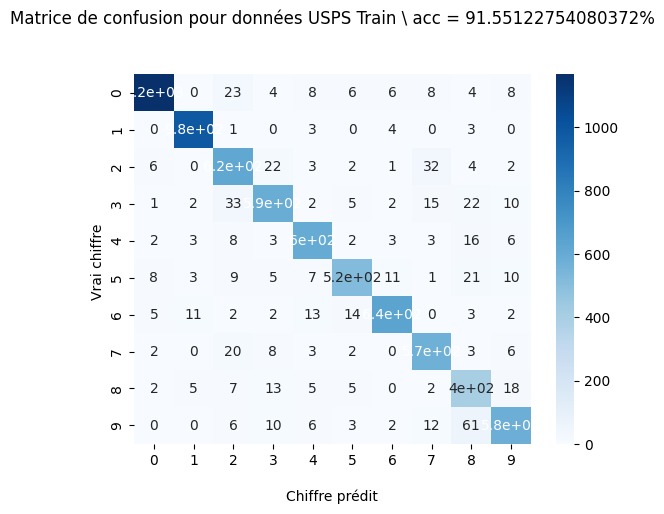

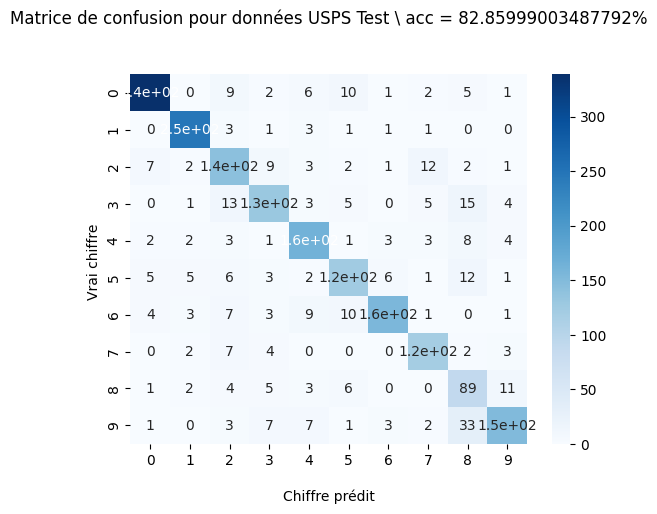

In [13]:
main_Conv1d()